In [1]:
"""
=============================================================================
UYGULAMA 03 — Pipeline, ColumnTransformer & Random Forest
=============================================================================
Kapsam:
  - ColumnTransformer ile numerik + kategorik branch'leri birleştirme
  - Tam Pipeline kurma (preprocessing + model)
  - Pipeline'ı eğitme, test etme
  - GridSearchCV ile hiperparametre optimizasyonu
  - Sınıflandırma raporu, Confusion Matrix, ROC-AUC eğrisi
  - Modeli ve pipeline'ı kaydetme (joblib)

Veri seti: UCI Bank Marketing (ya da örnek veri)
Kurulum:   pip install scikit-learn pandas numpy matplotlib seaborn joblib
=============================================================================
"""

"\n=============================================================================\nUYGULAMA 03 — Pipeline, ColumnTransformer & Random Forest\n=============================================================================\nKapsam:\n  - ColumnTransformer ile numerik + kategorik branch'leri birleştirme\n  - Tam Pipeline kurma (preprocessing + model)\n  - Pipeline'ı eğitme, test etme\n  - GridSearchCV ile hiperparametre optimizasyonu\n  - Sınıflandırma raporu, Confusion Matrix, ROC-AUC eğrisi\n  - Modeli ve pipeline'ı kaydetme (joblib)\n\nVeri seti: UCI Bank Marketing (ya da örnek veri)\nKurulum:   pip install scikit-learn pandas numpy matplotlib seaborn joblib\n=============================================================================\n"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    GridSearchCV, cross_val_score,
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay,
)
import warnings
warnings.filterwarnings("ignore")


In [3]:
plt.rcParams.update({"font.family": "sans-serif",
                     "axes.spines.top": False, "axes.spines.right": False})

print("=" * 60)
print("  UYGULAMA 02 — Pipeline, ColumnTransformer & RF")
print("=" * 60)


  UYGULAMA 02 — Pipeline, ColumnTransformer & RF


In [4]:
# ═════════════════════════════════════════════════════════════
# 1. VERİ HAZIRLAMA
# ═════════════════════════════════════════════════════════════
print("\n[1] Veri hazırlanıyor...")

url = ("https://archive.ics.uci.edu/ml/machine-learning-databases"
       "/00222/bank-additional-full.csv")
try:
    df = pd.read_csv(url, sep=";")
    print(f"    ✅ UCI Bank Marketing: {df.shape}")
except Exception:
    print("    ⚠️  Örnek veri oluşturuluyor...")
    np.random.seed(42)
    n = 5000
    df = pd.DataFrame({
        "age":       np.random.randint(18, 75, n).astype(float),
        "balance":   np.random.normal(1500, 3000, n),
        "duration":  np.abs(np.random.normal(260, 260, n)),
        "campaign":  np.random.randint(1, 10, n).astype(float),
        "pdays":     np.random.choice(
                         [999] + list(range(0, 30)), n,
                         p=[0.85] + [0.005] * 30).astype(float),
        "previous":  np.random.randint(0, 5, n).astype(float),
        "job":       np.random.choice(
                         ["admin.", "blue-collar", "technician",
                          "services", "management", "retired"], n),
        "marital":   np.random.choice(["married", "single", "divorced"], n),
        "education": np.random.choice(
                         ["basic.4y", "high.school",
                          "university.degree", "professional.course"], n),
        "contact":   np.random.choice(["telephone", "cellular"], n),
        "poutcome":  np.random.choice(
                         ["failure", "success", "nonexistent"], n),
        "y": None,
    })
    prob = (0.05
            + 0.25 * (df["duration"] > 350)
            + 0.12 * (df["previous"] > 0)
            + 0.10 * (df["poutcome"] == "success")).clip(0.02, 0.95)
    df["y"] = np.where(np.random.rand(n) < prob, "yes", "no")
    # Yapay eksikler
    for c in ["age", "balance"]:
        df.loc[np.random.rand(n) < 0.05, c] = np.nan
    for c in ["job", "education"]:
        df.loc[np.random.rand(n) < 0.07, c] = np.nan

df["target"] = (df["y"] == "yes").astype(int)
print(f"    Hedef dağılımı: {df['target'].value_counts().to_dict()}")

# Kolon grupları
num_cols = [c for c in ["age", "balance", "duration",
                         "campaign", "pdays", "previous"]
            if c in df.columns]
cat_ohe  = [c for c in ["job", "marital", "contact", "poutcome"]
            if c in df.columns]
cat_ord  = [c for c in ["education"] if c in df.columns]

X = df[num_cols + cat_ohe + cat_ord]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"    Eğitim: {X_train.shape[0]:,}  |  Test: {X_test.shape[0]:,}")



[1] Veri hazırlanıyor...
    ⚠️  Örnek veri oluşturuluyor...
    Hedef dağılımı: {0: 3663, 1: 1337}
    Eğitim: 4,000  |  Test: 1,000


In [5]:
# ═════════════════════════════════════════════════════════════
# 2. BRANCH PIPELINE'LARI
# ═════════════════════════════════════════════════════════════
print("\n[2] Branch pipeline'ları kuruluyor...")

# ── Sayısal branch ────────────────────────────────────────────
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])

# ── Kategorik branch — OHE ────────────────────────────────────
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False,
        drop="if_binary",      # Binary sütun tek sütuna düşer
    )),
])

# ── Kategorik branch — Ordinal (education) ───────────────────
ordinal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1,
    )),
])

print("    ✅ numeric_pipeline  : Imputer(median) → StandardScaler")
print("    ✅ categorical_pipeline: Imputer(mode) → OneHotEncoder")
print("    ✅ ordinal_pipeline  : Imputer(mode) → OrdinalEncoder")




[2] Branch pipeline'ları kuruluyor...
    ✅ numeric_pipeline  : Imputer(median) → StandardScaler
    ✅ categorical_pipeline: Imputer(mode) → OneHotEncoder
    ✅ ordinal_pipeline  : Imputer(mode) → OrdinalEncoder


In [6]:
# ═════════════════════════════════════════════════════════════
# 3. COLUMNTRANSFORMER
# ═════════════════════════════════════════════════════════════
print("\n[3] ColumnTransformer oluşturuluyor...")

preprocessor = ColumnTransformer(
    transformers=[
        ("num",     numeric_pipeline,      num_cols),
        ("cat_ohe", categorical_pipeline,  cat_ohe),
        ("cat_ord", ordinal_pipeline,      cat_ord),
    ],
    remainder="drop",  # Listelenmeyen sütunları at
)



[3] ColumnTransformer oluşturuluyor...


In [7]:
# ═════════════════════════════════════════════════════════════
# 4. TAM PIPELINE
# ═════════════════════════════════════════════════════════════
print("\n[4] Tam Pipeline oluşturuluyor...")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier",   RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=4,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
    )),
])

# İlk eğitim
print("    ⏳ Pipeline eğitiliyor (varsayılan parametreler)...")
pipeline.fit(X_train, y_train)

y_pred  = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("\n    Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred, target_names=["No", "Yes"]))
print(f"    ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")



[4] Tam Pipeline oluşturuluyor...
    ⏳ Pipeline eğitiliyor (varsayılan parametreler)...

    Sınıflandırma Raporu:
              precision    recall  f1-score   support

          No       0.80      0.75      0.78       733
         Yes       0.42      0.49      0.45       267

    accuracy                           0.68      1000
   macro avg       0.61      0.62      0.61      1000
weighted avg       0.70      0.68      0.69      1000

    ROC-AUC: 0.6716


In [8]:
# ═════════════════════════════════════════════════════════════
# 5. GRİDSEARCHCV
# ═════════════════════════════════════════════════════════════
print("[5] GridSearchCV ile hiperparametre optimizasyonu...")
print("    ⏳ Çalışıyor (birkaç dakika sürebilir)...")

param_grid = {
    # Pipeline adı 'classifier' olduğu için __ ile erişilir
    "classifier__n_estimators":     [50, 100, 200],
    "classifier__max_depth":        [None, 10, 20],
    "classifier__min_samples_leaf": [2, 4],
    "classifier__max_features":     ["sqrt", "log2"],
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
)
gs.fit(X_train, y_train)

print(f"\n    En iyi parametreler:")
for k, v in gs.best_params_.items():
    print(f"      {k.replace('classifier__',''):<25}: {v}")
print(f"\n    En iyi CV AUC: {gs.best_score_:.4f}")

# Tuned model
best_pipeline = gs.best_estimator_
y_pred_best  = best_pipeline.predict(X_test)
y_proba_best = best_pipeline.predict_proba(X_test)[:, 1]

print(f"    Test AUC (tuned): {roc_auc_score(y_test, y_proba_best):.4f}")
print(f"\n    Tuned Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_best, target_names=["No", "Yes"]))


[5] GridSearchCV ile hiperparametre optimizasyonu...
    ⏳ Çalışıyor (birkaç dakika sürebilir)...

    En iyi parametreler:
      max_depth                : 10
      max_features             : sqrt
      min_samples_leaf         : 4
      n_estimators             : 200

    En iyi CV AUC: 0.6645
    Test AUC (tuned): 0.6788

    Tuned Sınıflandırma Raporu:
              precision    recall  f1-score   support

          No       0.81      0.75      0.78       733
         Yes       0.43      0.52      0.47       267

    accuracy                           0.69      1000
   macro avg       0.62      0.64      0.63      1000
weighted avg       0.71      0.69      0.70      1000



In [9]:
# ═════════════════════════════════════════════════════════════
# 6. CROSS-VALIDATION SKORU
# ═════════════════════════════════════════════════════════════
print("[6] 5-Fold Cross-Validation skoru hesaplanıyor...")

cv_scores = cross_val_score(
    best_pipeline, X_train, y_train,
    cv=cv_strategy, scoring="roc_auc", n_jobs=-1
)
print(f"    CV Skorları: {cv_scores.round(4).tolist()}")
print(f"    Ortalama: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


[6] 5-Fold Cross-Validation skoru hesaplanıyor...
    CV Skorları: [0.6645, 0.6638, 0.6373, 0.6259, 0.7309]
    Ortalama: 0.6645 ± 0.0364



[7] Görselleştirmeler hazırlanıyor...


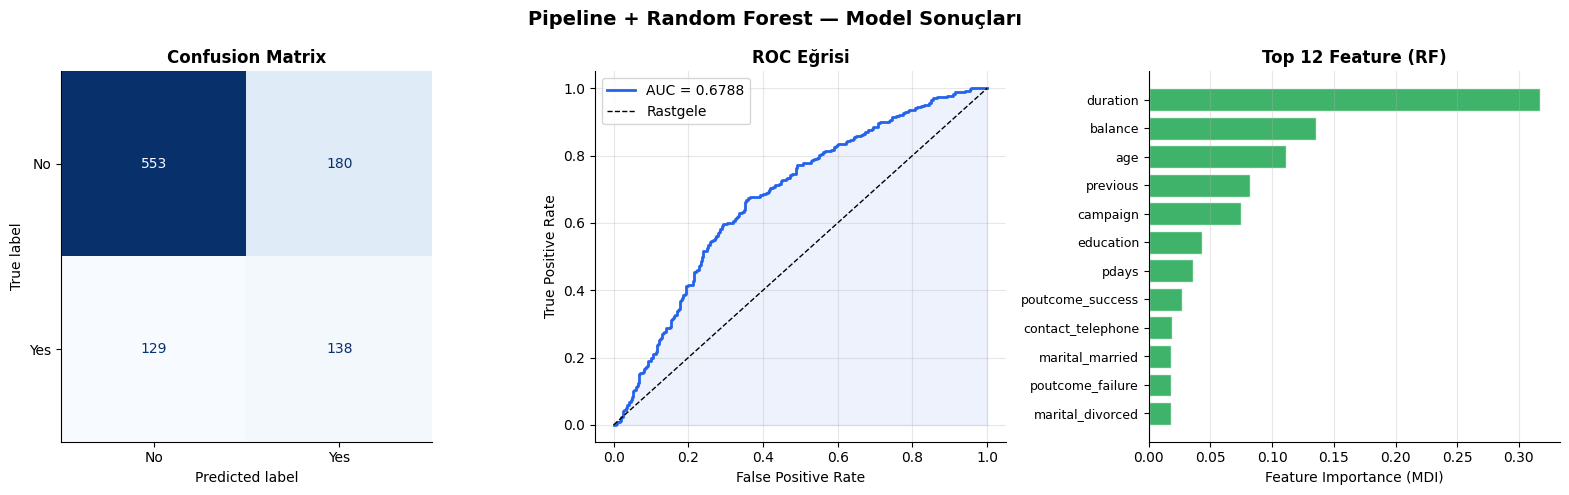

    ✅ Grafik kaydedildi: 02_pipeline_rf_sonuclar.png


In [11]:
# ═════════════════════════════════════════════════════════════
# 7. GÖRSELLEŞTİRME
# ═════════════════════════════════════════════════════════════
print("\n[7] Görselleştirmeler hazırlanıyor...")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Pipeline + Random Forest — Model Sonuçları",
             fontsize=14, fontweight="bold")

# ── 7a. Confusion Matrix ──────────────────────────────────────
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(cm, display_labels=["No", "Yes"])
disp.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Confusion Matrix", fontweight="bold")

# ── 7b. ROC Eğrisi ───────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_test, y_proba_best)
auc = roc_auc_score(y_test, y_proba_best)
axes[1].plot(fpr, tpr, color="#2563EB", lw=2, label=f"AUC = {auc:.4f}")
axes[1].fill_between(fpr, tpr, alpha=0.08, color="#2563EB")
axes[1].plot([0, 1], [0, 1], "k--", lw=1, label="Rastgele")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Eğrisi", fontweight="bold")
axes[1].legend()
axes[1].grid(alpha=0.3)

# ── 7c. Feature Importance ───────────────────────────────────
rf_model = best_pipeline.named_steps["classifier"]
importances = rf_model.feature_importances_

try:
    feat_names = list(
        best_pipeline.named_steps["preprocessor"].get_feature_names_out()
    )
    feat_names = [f.replace("cat_ohe__", "").replace("num__", "")
                    .replace("cat_ord__", "") for f in feat_names]
except Exception:
    feat_names = [f"F{i}" for i in range(len(importances))]

top_n = 12
top_idx = np.argsort(importances)[-top_n:]
axes[2].barh(
    range(top_n),
    importances[top_idx],
    color="#16A34A", alpha=0.82, edgecolor="white"
)
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels(
    [feat_names[i] if i < len(feat_names) else f"F{i}" for i in top_idx],
    fontsize=9
)
axes[2].set_xlabel("Feature Importance (MDI)")
axes[2].set_title(f"Top {top_n} Feature (RF)", fontweight="bold")
axes[2].grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig("03_pipeline_rf_sonuclar.png", dpi=150, bbox_inches="tight")
plt.show()
print("    ✅ Grafik kaydedildi: 02_pipeline_rf_sonuclar.png")
plt.close()


In [12]:
# ═════════════════════════════════════════════════════════════
# 8. MODELİ KAYDET
# ═════════════════════════════════════════════════════════════
print("\n[8] Model kaydediliyor...")

joblib.dump(best_pipeline, "best_pipeline.pkl")
print("    ✅ Kaydedildi: best_pipeline.pkl")

# Yükleme testi
loaded = joblib.load("best_pipeline.pkl")
auc_check = roc_auc_score(y_test, loaded.predict_proba(X_test)[:, 1])
print(f"    Yükleme testi AUC: {auc_check:.4f} ✓")



[8] Model kaydediliyor...
    ✅ Kaydedildi: best_pipeline.pkl
    Yükleme testi AUC: 0.6788 ✓


In [13]:
# ═════════════════════════════════════════════════════════════
# 9. PIPELINE ÖZETİ
# ═════════════════════════════════════════════════════════════
print("\n" + "─" * 50)
print("  PIPELINE YAPISI (best_pipeline):")
print("─" * 50)
for step_name, step in best_pipeline.steps:
    print(f"  [{step_name}]")
    if hasattr(step, "transformers"):
        for tname, t, cols in step.transformers:
            print(f"    └─ {tname}: {type(t).__name__} ({len(cols)} sütun)")

print("\n" + "=" * 60)
print("  ✅ UYGULAMA 02 TAMAMLANDI")
print("  Çıktılar: 03_pipeline_rf_sonuclar.png | best_pipeline.pkl")
print("=" * 60)



──────────────────────────────────────────────────
  PIPELINE YAPISI (best_pipeline):
──────────────────────────────────────────────────
  [preprocessor]
    └─ num: Pipeline (6 sütun)
    └─ cat_ohe: Pipeline (4 sütun)
    └─ cat_ord: Pipeline (1 sütun)
  [classifier]

  ✅ UYGULAMA 02 TAMAMLANDI
  Çıktılar: 03_pipeline_rf_sonuclar.png | best_pipeline.pkl
